In [1]:
import arcpy
import sys
sys.path.append("../src")
from utils import Utils
from landforms import Landforms
from processDem import ProcessDem
from rasterMasking import RasterMasking
import os, glob

# 1. Align all rasters, including backscatter and higher resolution files to the 1-m DEM

In [ ]:
# ================= CONFIGURATION =================
REEF_NAME = "BayHarbor"  # Name of the reef directory
ABRV = "BH"
BASE_DIR = fr"C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts"

# List resolutions in priority order (first valid one found becomes the reference/snap raster) - also the subfolder names
TARGET_RESOLUTIONS = ["1m", "0.5m", "0.25m"]

# Define markers used in filenames
DEM_MARKER = "BY"  # Bathymetry
BS_MARKER = "BS"   # Backscatter

PRODUCTS = ["slope", "aspect", "roughness", "tpi", "tri", "hillshade", "shannon_index"]
# =================================================

In [3]:
# Alignment Code

# --- 1. Identify Inputs ---
REEF_DIR = os.path.join(BASE_DIR, REEF_NAME)
input_dems = Utils.find_rasters(REEF_DIR, ABRV, TARGET_RESOLUTIONS, DEM_MARKER)
input_bss = Utils.find_rasters(REEF_DIR, ABRV, TARGET_RESOLUTIONS, BS_MARKER)

# Basic validation
if not input_dems:
    raise FileNotFoundError(f"No DEMs found in {REEF_DIR} for resolutions {TARGET_RESOLUTIONS}")

print(f"FOUND DEMS ({len(input_dems)}):")
print("\n".join([f"  - {os.path.basename(f)}" for f in input_dems]))

if input_bss:
    print(f"FOUND BACKSCATTER ({len(input_bss)}):")
    print("\n".join([f"  - {os.path.basename(f)}" for f in input_bss]))
else:
    print("NO BACKSCATTER FILES FOUND. Proceeding with DEMs only.")

print(f"PRODUCTS: {PRODUCTS}")

# --- 2. Combine for Processing ---
# Combine lists. DEMs first ensures the highest res DEM is the primary snap raster
input_rasters_list = input_dems + input_bss

# --- 3. Create Intersection Mask and Align ---
# This aligns everything to the first raster in the list (the highest priority DEM)
intersection_mask, aligned_rasters_list = RasterMasking.return_valid_data_mask_intersection(input_rasters_list)
# --- 4. Separate Outputs back into DEM and BS ---
# Using case-insensitive check for robustness
aligned_bss = [f for f in aligned_rasters_list if f"_{BS_MARKER}_".lower() in os.path.basename(f).lower()]
aligned_dems = [f for f in aligned_rasters_list if f not in aligned_bss]

# --- 5. Final Validation ---
print("-" * 30)
print("PROCESSING COMPLETE")
print(f"Aligned DEMs: {len(aligned_dems)}")
print(f"Aligned BS:   {len(aligned_bss)}")

# Verify we didn't lose any DEMs during the intersection process
if len(aligned_dems) != len(input_dems):
    print(f"WARNING: Input DEM count ({len(input_dems)}) matches Aligned DEM count ({len(aligned_dems)})? NO")
else:
    print("Validation: Input and Aligned DEM counts match.")

# --- 6. Cleanup ---
print("-" * 30)
print("STARTING CLEANUP")

# Collect all files involved (Inputs, Aligned Outputs, and the Mask)
all_involved_files = input_rasters_list + aligned_rasters_list
if intersection_mask:
    all_involved_files.append(intersection_mask)

# Extract unique directories using a set comprehension
# This prevents trying to clean the same folder multiple times
cleanup_dirs = {os.path.dirname(f) for f in all_involved_files if f and os.path.exists(os.path.dirname(f))}

# Iterate and clean
for directory in cleanup_dirs:
    # Optional: Print where we are cleaning
    Utils.remove_additional_files(directory=directory)

print("Cleanup Complete.")

FOUND DEMS (2):
  - TS_BY_1m.tif
  - TS_BY_0.5m.tif
FOUND BACKSCATTER (2):
  - TS_BS_1m.tif
  - TS_BS_0.5m.tif
PRODUCTS: ['slope', 'aspect', 'roughness', 'tpi', 'tri', 'hillshade', 'shannon_index']
Starting raster processing loop...
Saving intersection mask to: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\all_raster_intersection_mask.tif
  Successfully deleted Temporary Workspace: C:\Users\ageglio\AppData\Local\Temp\2\tmpv9glmg3k   
  Successfully deleted Local Temporary Workspace: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\boundary_files\all_raster_intersection_mask_local_temp   
Temporary file cleanup process completed successfully.                                                                                                                                                       
Finished generating intersection mask
------------------------------
PROCESSING COMPLETE
Ali

# 2. Generate derived DEM products

In [ ]:
# Generate terrain products of all of the dems and align the backscatter files
for input_dem, input_bs in zip(aligned_dems, aligned_bss):
    # Create an instance of the ProcessDEM class with the specified parameters
    generateHabitatDerivates = ProcessDem(
                                    input_dem=input_dem,
                                    input_bs=input_bs,
                                    binary_mask=intersection_mask,
                                    products=PRODUCTS,
                                    shannon_window=[3, 9, 21],
                                    fill_method="IDW",
                                    fill_iterations=1,
                                    divisions=2,  # Divide the height by this to run tile processing of DEM file, automatic overalap computed.
                                    generate_boundary=True
                                    )
    # Process the DEM and generate the habitat derivatives
    generateHabitatDerivates.process_dem()

ArcPy environment synchronized to: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\TS_BY_1m.tif
DEM NAME: TS_BY_1m
OUTPUT FOLDER: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\habitat_derivatives
  Successfully deleted Local Temporary Workspace: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\boundary_files\TS_BY_1m_local_temp   
Temporary file cleanup process completed WITH ERRORS. Some files/directories may not have been deleted. Please check logs above.
  Successfully deleted Local Temporary Workspace: C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\boundary_files\TS_BS_1m_local_temp   
Temporary file cleanup process completed WITH ERRORS. Some files/directories may not have been deleted. Please check logs above.
Trimmed raster saved to: C:\Users\ageglio\Documents\NLM_Data

## 3. Create geomorphons landforms using arcpy 3.4

In [5]:
# create original landforms from ArcGIS Pro
filled_dems = [glob.glob(os.path.join(os.path.dirname(dem), "filled", f"*{DEM_MARKER}*.tif")) for dem in input_dems]
filled_dems = [item for sublist in filled_dems for item in sublist]
for filled_dem in filled_dems:
    print("creating landforms for:", os.path.basename(filled_dem))
    landofrms_directory = Landforms(filled_dem).generate_landforms()
    # Clean up additional files after processing
    Utils.remove_additional_files(directory=landofrms_directory)

creating landforms for: TS_BY_1m_filled.tif
Modified raster data saved to C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\geomorphons\TS_BY_1m_filled_10c.tif
Modified raster data saved to C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\geomorphons\TS_BY_1m_filled_6c.tif
Modified raster data saved to C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\geomorphons\TS_BY_1m_filled_5c.tif
Modified raster data saved to C:\Users\ageglio\Documents\NLM_DataRelease\Updated_DataRelease_Surfaces_NewProducts\TraverseShoal\1m\geomorphons\TS_BY_1m_filled_4c.tif
Removed files: ['C:\\Users\\ageglio\\Documents\\NLM_DataRelease\\Updated_DataRelease_Surfaces_NewProducts\\TraverseShoal\\1m\\geomorphons\\TS_BY_1m_filled_bathymorphons.tfw', 'C:\\Users\\ageglio\\Documents\\NLM_DataRelease\\Updated_DataRelease_Surfaces_NewProducts\\TraverseShoal\\1m\\geomor

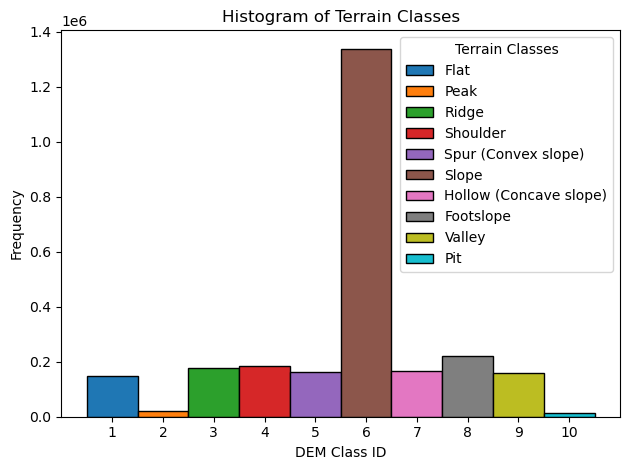

In [7]:
## If you want to save the landforms classification histogram and metadata
classes = "10"
input_dem = filled_dems[0]
raster_path = os.path.join(os.path.dirname(os.path.dirname(input_dem)), "geomorphons", Utils.sanitize_path_to_name(input_dem)+f"_{classes}c.tif")
Landforms.analyze_geomorphon_data(raster_path)

# 4. Tracklines to shapefile

In [ ]:
# allowing the user to run all without executing the trackline portion
assert 1==2

In [ ]:
import sys
import os
sys.path.append("../src")
from extents import GetExtents

# Define the output folder path for shapefiles
out_folder = "..\\shapefiles"
os.makedirs(out_folder, exist_ok=True)

trackline_folder = r"C:\Users\ageglio\Documents\NLM_DataRelease\FINAL_DataRelease_Files_21-23\BayHarborReef_2021 (1)\BayHarborReef_2021\Bay Harbor Reef_Tracklines"
print("folder path chosen: ", trackline_folder)

## combine and convert tracklines to a shapefile
# Removed threshold_seconds argument as it is no longer relevant for the file-based approach
GetExtents.create_tracklines(trackline_folder, out_folder, utm_zone=16)